## **Step 1 : importing Essential Libraries**



In [ ]:

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11) 
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
help(keras.applications)
print(keras.__version__)
from keras import backend as K 

Help on package keras.applications in keras:

NAME
    keras.applications

PACKAGE CONTENTS
    densenet
    imagenet_utils
    inception_resnet_v2
    inception_v3
    mobilenet
    mobilenet_v2
    nasnet
    resnet
    resnet50
    resnet_v2
    vgg16
    vgg19
    xception

FILE
    /usr/local/lib/python3.6/dist-packages/keras/applications/__init__.py


2.4.3


# **Step 2 : Loading pictures and making Dictionary of images and labels**

In [ ]:
'''folder_benign_train = '/content/drive/My Drive/Melanoma_project/train/benign'
folder_malignant_train = '/content/drive/My Drive/Melanoma_project/train/malignant'

folder_benign_test = '/content/drive/My Drive/Melanoma_project/test/benign'
folder_malignant_test = '/content/drive/My Drive/Melanoma_project/test/malignant'
'''

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

read

<function __main__.<lambda>>

In [ ]:
from google.colab import drive
from pathlib import Path

drive.mount('/content/drive')
# ref : https://medium.com/datadriveninvestor/speed-up-your-image-training-on-google-colab-dc95ea1491cf

zip_path = '/content/drive/My Drive/Melanoma_project/image_folder.zip'
!cp "{zip_path}" .
!unzip -q image_folder.zip
!rm image_folder.zip  # to copy the zip from drive to colab and then get the data - makes the loading process much faster

Mounted at /content/drive


In [6]:
# Load in training pictures 
import os
ims_benign = [read(os.path.join('/content/train/benign', filename)) for filename in os.listdir('/content/train/benign')]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join('/content/train/malignant', filename)) for filename in os.listdir('/content/train/malignant')]
X_malignant = np.array(ims_malignant, dtype='uint8')


In [7]:
# Load in testing pictures

ims_benign = [read(os.path.join('/content/test/benign', filename)) for filename in os.listdir('/content/test/benign')]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join('/content/test/malignant', filename)) for filename in os.listdir('/content/test/malignant')]
X_malignant_test = np.array(ims_malignant, dtype='uint8')


In [8]:
# Create labels

y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])


In [9]:
# Merge data 
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

In [10]:
# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
print(len(X_train))
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
print(X_test)
print(len(X_test))
y_test = y_test[s]

2637
[[[[178 139 140]
   [188 144 141]
   [185 137 133]
   ...
   [185 147 146]
   [182 147 143]
   [184 144 144]]

  [[194 152 154]
   [205 157 155]
   [199 145 135]
   ...
   [200 155 150]
   [198 157 151]
   [199 154 149]]

  [[189 148 146]
   [201 158 152]
   [199 149 148]
   ...
   [193 148 143]
   [195 150 145]
   [193 148 142]]

  ...

  [[180 103 111]
   [194 107 113]
   [191 105 108]
   ...
   [194 147 141]
   [195 141 129]
   [191 143 129]]

  [[180 100 109]
   [191 100 107]
   [191 104 110]
   ...
   [195 146 139]
   [193 145 131]
   [190 142 130]]

  [[180 101 104]
   [188  96  99]
   [188  97 104]
   ...
   [193 140 124]
   [192 144 130]
   [191 143 133]]]


 [[[  5   5   5]
   [  6   6   6]
   [  7   7   7]
   ...
   [  5   5   5]
   [  4   4   4]
   [  4   4   4]]

  [[  5   5   5]
   [  6   6   6]
   [  7   7   7]
   ...
   [  5   5   5]
   [  5   5   5]
   [  4   4   4]]

  [[  6   6   6]
   [  7   7   7]
   [  8   8   8]
   ...
   [  5   5   5]
   [  5   5   5]
   [  

Trying to get rid of hair :

(224, 224, 3)


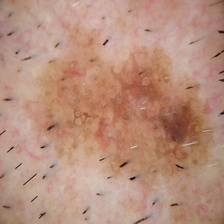

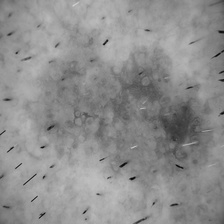

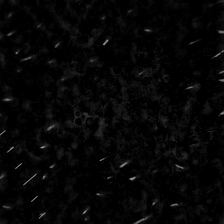

(224, 224)


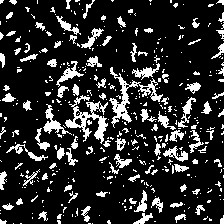

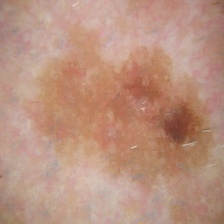

In [ ]:
import cv2
src = cv2.imread("/content/train/malignant/109.jpg")

print( src.shape )
from google.colab.patches import cv2_imshow
cv2_imshow( src )


# Convert the original image to grayscale
grayScale = cv2.cvtColor( src, cv2.COLOR_RGB2GRAY )
cv2_imshow(grayScale)
cv2.imwrite('grayScale_sample1.jpg', grayScale, [int(cv2.IMWRITE_JPEG_QUALITY), 90])

# Kernel for the morphological filtering
kernel = cv2.getStructuringElement(1,(17,17))

# Perform the blackHat filtering on the grayscale image to find the 
# hair countours
blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
cv2_imshow(blackhat)
cv2.imwrite('blackhat_sample1.jpg', blackhat, [int(cv2.IMWRITE_JPEG_QUALITY), 90])

# intensify the hair countours in preparation for the inpainting 
# algorithm
ret,thresh2 = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)
print( thresh2.shape )
cv2_imshow(thresh2)
cv2.imwrite('thresholded_sample1.jpg', thresh2, [int(cv2.IMWRITE_JPEG_QUALITY), 90])

# inpaint the original image depending on the mask
dst = cv2.inpaint(src,thresh2,1,cv2.INPAINT_TELEA)
cv2_imshow(dst)
#cv2.imwrite('C:\\SkinHairRemovalPython\\InPainted_sample1.jpg', dst, [int(cv2.IMWRITE_JPEG_QUALITY), 90])

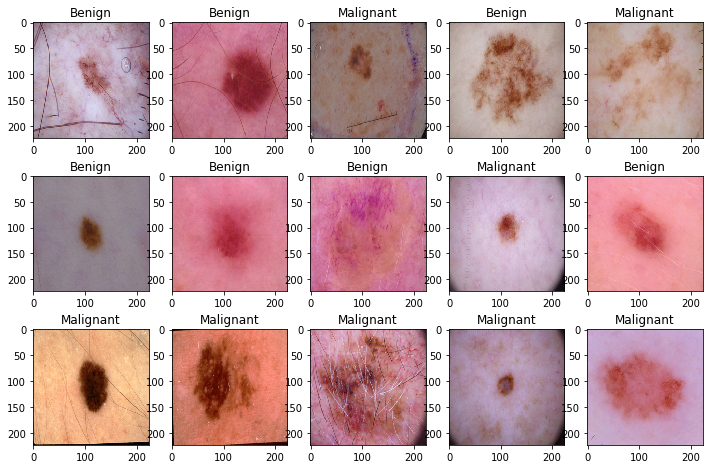

In [ ]:
# Display first 15 images of moles, and how they are classified
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

## **Step 3: Categorical Labels**

In [ ]:
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

## **Step 4 : Normalization**

In [ ]:
# With data augmentation to prevent overfitting 
X_train = X_train/255.
X_test = X_test/255.

# **Trying out Xception**

In [ ]:
#Declaring stuff :
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',    
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)

Epoch 1/50
33/33 - 28s - loss: 0.5022 - accuracy: 0.7847 - val_loss: 0.6927 - val_accuracy: 0.5360
Epoch 2/50
33/33 - 25s - loss: 0.4062 - accuracy: 0.8141 - val_loss: 0.6921 - val_accuracy: 0.5360
Epoch 3/50
33/33 - 25s - loss: 0.3699 - accuracy: 0.8274 - val_loss: 0.6917 - val_accuracy: 0.5360
Epoch 4/50
33/33 - 25s - loss: 0.3537 - accuracy: 0.8364 - val_loss: 0.6913 - val_accuracy: 0.5360
Epoch 5/50
33/33 - 25s - loss: 0.3338 - accuracy: 0.8487 - val_loss: 0.6908 - val_accuracy: 0.5360
Epoch 6/50

Epoch 00006: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
33/33 - 25s - loss: 0.3154 - accuracy: 0.8511 - val_loss: 0.6905 - val_accuracy: 0.5360
Epoch 7/50
33/33 - 25s - loss: 0.2989 - accuracy: 0.8672 - val_loss: 0.6904 - val_accuracy: 0.5360
Epoch 8/50
33/33 - 25s - loss: 0.2894 - accuracy: 0.8677 - val_loss: 0.6906 - val_accuracy: 0.5360
Epoch 9/50
33/33 - 25s - loss: 0.2771 - accuracy: 0.8715 - val_loss: 0.6915 - val_accuracy: 0.5360
Epoch 10/50
33/33 - 25s - lo

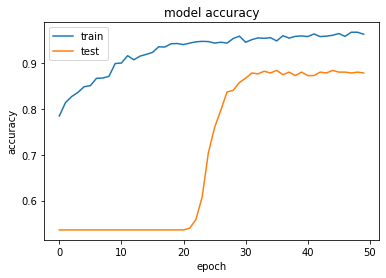

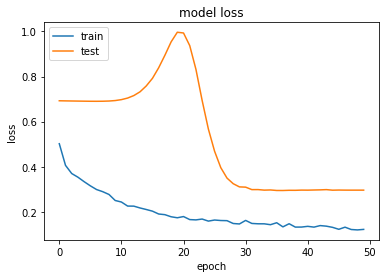

In [ ]:
input_shape = (224,224,3)
lr = 1e-5
epochs = 50
batch_size = 64

model = Xception(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)

model.compile(optimizer = Adam(lr) ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=2, 
                    callbacks=[learning_rate_reduction]
                   )

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# my comments :  

In [ ]:
# Train Xception on all the data
model.fit(X_train, y_train,
          epochs=epochs, batch_size= epochs, verbose=2,
          callbacks=[learning_rate_reduction]
         )

Epoch 1/50
53/53 - 31s - loss: 0.1794 - accuracy: 0.9325
Epoch 2/50
53/53 - 30s - loss: 0.1681 - accuracy: 0.9401
Epoch 3/50
53/53 - 30s - loss: 0.1682 - accuracy: 0.9386
Epoch 4/50
53/53 - 30s - loss: 0.1677 - accuracy: 0.9405
Epoch 5/50
53/53 - 30s - loss: 0.1631 - accuracy: 0.9389
Epoch 6/50
53/53 - 30s - loss: 0.1672 - accuracy: 0.9424
Epoch 7/50
53/53 - 30s - loss: 0.1586 - accuracy: 0.9511
Epoch 8/50
53/53 - 30s - loss: 0.1618 - accuracy: 0.9469
Epoch 9/50
53/53 - 30s - loss: 0.1626 - accuracy: 0.9465
Epoch 10/50
53/53 - 30s - loss: 0.1686 - accuracy: 0.9439
Epoch 11/50
53/53 - 30s - loss: 0.1621 - accuracy: 0.9439
Epoch 12/50
53/53 - 30s - loss: 0.1679 - accuracy: 0.9412
Epoch 13/50
53/53 - 30s - loss: 0.1685 - accuracy: 0.9405
Epoch 14/50
53/53 - 30s - loss: 0.1584 - accuracy: 0.9477
Epoch 15/50
53/53 - 30s - loss: 0.1598 - accuracy: 0.9458
Epoch 16/50
53/53 - 30s - loss: 0.1691 - accuracy: 0.9378
Epoch 17/50
53/53 - 30s - loss: 0.1658 - accuracy: 0.9427
Epoch 18/50
53/53 - 30s

In [ ]:
# save model
model.save('/content/drive/My Drive/Melanoma_project/xception_saved_model.h5')

# Testing model on test data to evaluate
y_pred = model.predict(X_test)
print(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, fbeta_score, classification_report

# Accuracy
print("accuracy score : ",accuracy_score(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1)))
# Precision
print("precision score : ",precision_score(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1)))
# Recall
print("recall score : ",recall_score(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1)))
# F1-score
print("f1 score : ",f1_score(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1)))
# F-beta-score
print("f beta score : ",fbeta_score(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1),beta=10))
# confusion matrix:
print("confusion matrix : ",confusion_matrix(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1)))

'''
# save model
# serialize model to JSON
Xception_json = model.to_json()

with open("Xception.json", "w") as json_file:
    json_file.write(Xception_json)
    
# serialize weights to HDF5
model.save_weights("Xception.h5")
print("Saved model to disk")

# my comments : 
'''

0.8681818181818182
accuracy score :  0.8681818181818182
precision score :  0.8402555910543131
recall score :  0.8766666666666667
f1 score :  0.8580750407830342
f beta score :  0.8762907003595818
confusion matrix :  [[310  50]
 [ 37 263]]


'\n# save model\n# serialize model to JSON\nXception_json = model.to_json()\n\nwith open("Xception.json", "w") as json_file:\n    json_file.write(Xception_json)\n    \n# serialize weights to HDF5\nmodel.save_weights("Xception.h5")\nprint("Saved model to disk")\n\n# my comments : \n'

In [ ]:
'''
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score, classification_report
confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
f1_score(y_test, y_predict)  # taken from LogisticReg.ipynb
'''

ValueError: ignored

# **--------------------------------------------------------------------**

# **Step 5: Model Building**

**CNN**

I used the Keras Sequential API, where you have just to add one layer at a time, starting from the input.

The first is the convolutional (Conv2D) layer. It is like a set of learnable filters. I choosed to set 64 filters for the two firsts conv2D layers. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image.

The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

The second important layer in CNN is the pooling (MaxPool2D) layer. This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. We have to choose the pooling size (i.e the area size pooled each time) more the pooling dimension is high, more the downsampling is important.

Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.

Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network.

The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

In the end i used the features in one fully-connected (Dense) layer which is just artificial an neural networks (ANN) classifier.

In [ ]:
# See learning curve and validation curve

def build(input_shape= (224,224,3), lr = 1e-3, num_classes= 2,
          init= 'normal', activ= 'relu', optim= 'adam'):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',input_shape=input_shape,
                     activation= activ, kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same', 
                     activation =activ, kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()

    if optim == 'rmsprop':
        optimizer = RMSprop(lr=lr)

    else:
        optimizer = Adam(lr=lr)

    model.compile(optimizer = optimizer ,loss = "binary_crossentropy", metrics=["accuracy"])
    return model

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',    
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)

In [ ]:
input_shape = (224,224,3)
lr = 1e-5
init = 'normal'
activ = 'relu'
optim = 'adam'
epochs = 50  # originally : 50
batch_size = 64

model = build(lr=lr, init= init, activ= activ, optim=optim, input_shape= input_shape)

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=0, 
                    callbacks=[learning_rate_reduction]
                   )
                   
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
K.clear_session()
del model
del history

# **Step 6: Cross-Validating Model**

In [ ]:
# define 3-fold cross validation test harness
kfold = KFold(n_splits=3, shuffle=True, random_state=11)

cvscores = []

for train, test in kfold.split(X_train, y_train):
  # create model
    
    model = build(lr=lr, 
                  init= init, 
                  activ= activ, 
                  optim=optim, 
                  input_shape= input_shape)
    
    # Fit the model
    model.fit(X_train[train], y_train[train], epochs=epochs, batch_size=batch_size, verbose=0)
    # evaluate the model
    scores = model.evaluate(X_train[test], y_train[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    K.clear_session()
    del model
    break
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))


# **Step 7: Testing the model**

In [ ]:
# Fitting model to all data
model = build(lr=lr, 
              init= init, 
              activ= activ, 
              optim=optim, 
              input_shape= input_shape)

model.fit(X_train, y_train,
          epochs=epochs, batch_size= batch_size, verbose=0,
          callbacks=[learning_rate_reduction]
         )

# Testing model on test data to evaluate
y_pred = model.predict_classes(X_test)

print(accuracy_score(np.argmax(y_test, axis=1),y_pred))

In [ ]:
# save model
# serialize model to JSON
model_json = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

# Clear memory, because of memory overload
del model
K.clear_session()

# **Step 8: ResNet101**

The CNN above is not a very sophisticated model, thus the resnet50, is also tried

In [ ]:
input_shape = (224,224,3)
lr = 1e-5
epochs = 50
batch_size = 64

model = ResNet50(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)

model.compile(optimizer = Adam(lr) ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=2, 
                    callbacks=[learning_rate_reduction]
                   )

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Train ResNet50 on all the data
model.fit(X_train, y_train,
          epochs=epochs, batch_size= epochs, verbose=0,
          callbacks=[learning_rate_reduction]
         )

In [ ]:
# Testing model on test data to evaluate
y_pred = model.predict(X_test)
print(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

# save model
# serialize model to JSON
resnet50_json = model.to_json()

with open("resnet50.json", "w") as json_file:
    json_file.write(resnet50_json)
    
# serialize weights to HDF5
model.save_weights("resnet50.h5")
print("Saved model to disk")

In [ ]:
import json

with open("/var/log/colab-jupyter.log", "r") as fo:
  for line in fo:
    print(json.loads(line)['msg'])